In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
evp_data = pd.read_csv('evp_data.csv')

# Removing missing values less than 5% of the total values

threshold = len(evp_data) * 0.05

cols_to_drop = evp_data.columns[evp_data.isna().sum() <= threshold]

evp_data.dropna(subset=cols_to_drop, inplace=True)

evp_data = evp_data.drop(columns= ["VIN (1-10)", "State"])

evp_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257027 entries, 0 to 257634
Data columns (total 15 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   County                                             257027 non-null  object 
 1   City                                               257027 non-null  object 
 2   Postal Code                                        257027 non-null  float64
 3   Model Year                                         257027 non-null  int64  
 4   Make                                               257027 non-null  object 
 5   Model                                              257027 non-null  object 
 6   Electric Vehicle Type                              257027 non-null  object 
 7   Clean Alternative Fuel Vehicle (CAFV) Eligibility  257027 non-null  object 
 8   Electric Range                                     257027 non-null  float64
 9 

In [4]:
print(evp_data.select_dtypes(include='object').nunique())

County                                                39
City                                                 486
Make                                                  46
Model                                                179
Electric Vehicle Type                                  2
Clean Alternative Fuel Vehicle (CAFV) Eligibility      3
Vehicle Location                                     566
Electric Utility                                      75
dtype: int64


In [5]:
evp_data = evp_data.rename(columns= {
    'Electric Vehicle Type' : 'EV Type',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility' : 'CAFV',
    'Electric Utility' : 'EU',
    'Vehicle Location' : 'VL',
    'Legislative District' : 'LD'
})

evp_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257027 entries, 0 to 257634
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   County             257027 non-null  object 
 1   City               257027 non-null  object 
 2   Postal Code        257027 non-null  float64
 3   Model Year         257027 non-null  int64  
 4   Make               257027 non-null  object 
 5   Model              257027 non-null  object 
 6   EV Type            257027 non-null  object 
 7   CAFV               257027 non-null  object 
 8   Electric Range     257027 non-null  float64
 9   Base MSRP          257027 non-null  float64
 10  LD                 257027 non-null  float64
 11  DOL Vehicle ID     257027 non-null  int64  
 12  VL                 257027 non-null  object 
 13  EU                 257027 non-null  object 
 14  2020 Census Tract  257027 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 31.4+ M

In [6]:
evp_data.head(2)

,County,City,Postal Code,Model Year,Make,Model,EV Type,CAFV,Electric Range,Base MSRP,LD,DOL Vehicle ID,VL,EU,2020 Census Tract
0,Yakima,Yakima,98901.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,15.0,347724772,POINT (-120.50729 46.60464),PACIFICORP,5.307700e+10
1,Kitsap,Port Orchard,98367.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,35.0,272165288,POINT (-122.68471 47.50524),PUGET SOUND ENERGY INC,5.303509e+10


In [8]:
evp_data["EV Type"].value_counts()

EV Type
Battery Electric Vehicle (BEV)            204660
Plug-in Hybrid Electric Vehicle (PHEV)     52367
Name: count, dtype: int64

In [9]:
evp_data["EV Type"] = np.where(evp_data["EV Type"] == 'Battery Electric Vehicle (BEV)', 1, 0)

evp_data.head(2)

,County,City,Postal Code,Model Year,Make,Model,EV Type,CAFV,Electric Range,Base MSRP,LD,DOL Vehicle ID,VL,EU,2020 Census Tract
0,Yakima,Yakima,98901.0,2019,TESLA,MODEL 3,1,Clean Alternative Fuel Vehicle Eligible,220.0,0.0,15.0,347724772,POINT (-120.50729 46.60464),PACIFICORP,5.307700e+10
1,Kitsap,Port Orchard,98367.0,2024,JEEP,WRANGLER,0,Not eligible due to low battery range,21.0,0.0,35.0,272165288,POINT (-122.68471 47.50524),PUGET SOUND ENERGY INC,5.303509e+10


In [10]:
# Random State

rv = 12

In [12]:
X = evp_data.drop(columns=['EV Type', 'DOL Vehicle ID', 'VL'])
y = evp_data["EV Type"]

# Select categorical and numeric column

categorical_col = ["County", "City", "Make", "Model", "CAFV", "EU"]
numeric = ["Model Year", "Electric Range", "Base MSRP", "Postal Code", "LD", "2020 Census Tract"]

# Preprocessor

preprocessor = ColumnTransformer(
    transformers= [
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_col)
    ]
)

# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = rv)


# Pipeline

clf = Pipeline(steps= [
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=rv))
])

In [13]:
clf.fit(X_train, y_train)

print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

Train accuracy: 1.0
Test accuracy: 0.9992478180238364


In [14]:
print(y.value_counts(normalize=True))

EV Type
1    0.796259
0    0.203741
Name: proportion, dtype: float64


In [16]:
# KNN

knn = Pipeline(steps= [
    ("preprocessor", preprocessor),
    ("knn_model", KNeighborsClassifier(n_neighbors=6))])

knn.fit(X_train, y_train)

print("Train accuracy:", knn.score(X_train, y_train))
print("Test accuracy:", knn.score(X_test, y_test))

Train accuracy: 0.9981046921375293
Test accuracy: 0.9975748615596104


In [17]:
y_pred = clf.predict(X_test)
knn_pred = knn.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15539
           1       1.00      1.00      1.00     61570

    accuracy                           1.00     77109
   macro avg       1.00      1.00      1.00     77109
weighted avg       1.00      1.00      1.00     77109



In [20]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15539
           1       1.00      1.00      1.00     61570

    accuracy                           1.00     77109
   macro avg       0.99      1.00      1.00     77109
weighted avg       1.00      1.00      1.00     77109



In [21]:
# Identify key predictors that distinguish BEV from PHEV

importances = clf.named_steps["model"].feature_importances_
feature_names = clf.named_steps["preprocessor"].get_feature_names_out()
sorted_idx = np.argsort(importances)[::-1]

for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

num__Electric Range: 0.2126
cat__CAFV_Eligibility unknown as battery range has not been researched: 0.1333
cat__CAFV_Not eligible due to low battery range: 0.1254
cat__Make_TESLA: 0.0573
num__Model Year: 0.0544
cat__CAFV_Clean Alternative Fuel Vehicle Eligible: 0.0478
cat__Model_VOLT: 0.0281
cat__Make_TOYOTA: 0.0255
cat__Model_LEAF: 0.0193
cat__Make_JEEP: 0.0182


C:\Users\DELL\AppData\Local\Temp\ipykernel_1284\886726554.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")


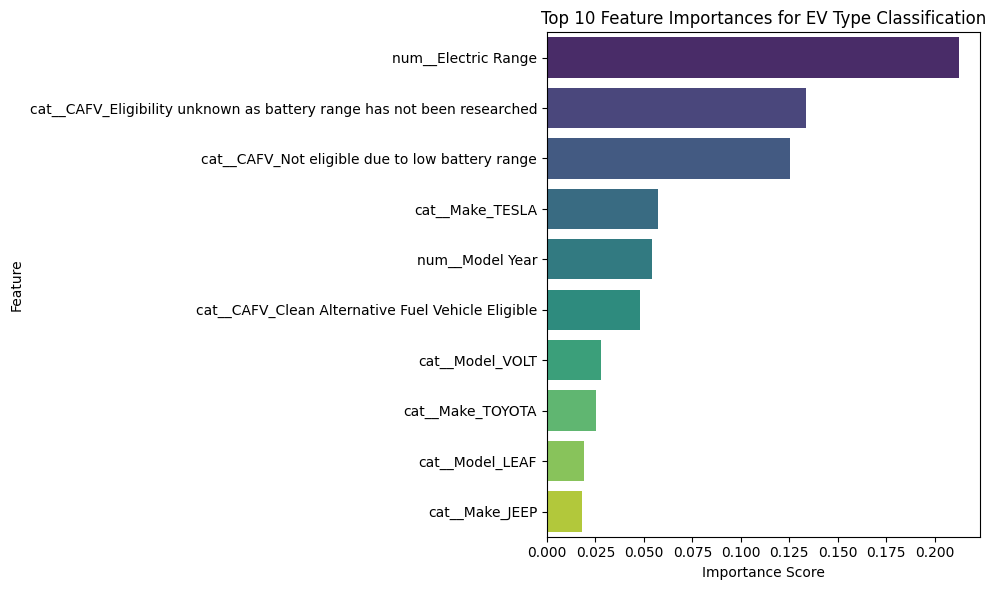

In [22]:
# Get top 10 features and their importances into a DataFrame
top_n = 10
feat_imp = pd.DataFrame({
    "Feature": [feature_names[i] for i in sorted_idx[:top_n]],
    "Importance": [importances[i] for i in sorted_idx[:top_n]]
})

# Plot with seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances for EV Type Classification")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [23]:
import pickle

with open("rf_model.pkl", "wb") as f:
    pickle.dump(clf, f)


In [24]:
with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)